In [1]:
import pandas as pd
from pyspark.sql.functions import (col, rand, udf, collect_set, collect_list, concat, array_distinct, flatten, when, length)
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StringType, FloatType
from unidecode import unidecode
import re
from functools import reduce
import numpy as np
import tensorflow as tf
import keras
from fuzzywuzzy import fuzz

from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, GlobalMaxPooling1D, Layer, Masking, Lambda, Permute
import os
import pickle
from keras.layers import Bidirectional
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import functools
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout, concatenate
from keras.activations import relu
from sklearn.model_selection import train_test_split

In [2]:
#env: geoNames

In [3]:
geonames_pairs = catalog.load('geonames_latin_pairs')
geonames_pairs = geonames_pairs.withColumn('target', when(col('match') == 'true', 1).otherwise(0).cast(FloatType()))

[08/22/23 16:10:17] INFO     Loading data from 'geonames_latin_pairs' (SparkDataSet)...         ]8;id=705859;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=137384;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

In [4]:
geonames_pairs.groupBy('language_1').count().orderBy(col('count').desc()).limit(200).show()

+----------+------+
|language_1| count|
+----------+------+
|        CN|503487|
|        IR|282669|
|        RU|234588|
|        TH|174396|
|        AF|171604|
|        NO|109708|
|        KR|104579|
|        TW| 85863|
|        JP| 81481|
|        IQ| 59890|
|        FR| 58277|
|        PK| 55530|
|        TR| 49718|
|        SE| 47650|
|        EG| 47493|
|        SY| 45737|
|        GR| 41502|
|        YE| 40943|
|        UA| 39231|
|        MX| 37547|
+----------+------+
only showing top 20 rows



In [5]:
geonames_pairs.filter(col('language_1') == 'NL').limit(10).show()

+----------------+----------------+-------+-------+----------+----------+----------+----------+-----+------+
|          name_1|          name_2|   id_1|   id_2|alphabet_1|alphabet_2|language_1|language_2|match|target|
+----------------+----------------+-------+-------+----------+----------+----------+----------+-----+------+
|     Homsterland| Hultensche Leij|2753420|2753428|     LATIN|     LATIN|        NL|        NL|false|   0.0|
|       Wormingen|  Wormer en Jisp|2744170|2744172|     LATIN|     LATIN|        NL|        NL|false|   0.0|
|         De Neer|     Neyderveyrt|2750455|2750467|     LATIN|     LATIN|        NL|        NL|false|   0.0|
|     Spykerbosch|          Spronk|2746879|2746889|     LATIN|     LATIN|        NL|        NL|false|   0.0|
|    Sint Pancras|Sint Odilienberg|2747225|2747229|     LATIN|     LATIN|        NL|        NL|false|   0.0|
|Huis Voorstonden|          Voorst|2745279|2745297|     LATIN|     LATIN|        NL|        NL|false|   0.0|
|        Terheden| 

In [6]:
geonames_pairs_es = geonames_pairs.filter((col('language_1') == col('language_2')) & (col('language_1').isin(['ES', 'MX', 'AR', 'VE', 'FR', 'IT', 'GB', 'US', 'BR', 'DE', 'NL'])))

In [7]:
geonames_pairs_es.count()

195568

In [8]:
geonames_pairs_es.orderBy(rand()).show(100)

+--------------------+--------------------+--------+--------+----------+----------+----------+----------+-----+------+
|              name_1|              name_2|    id_1|    id_2|alphabet_1|alphabet_2|language_1|language_2|match|target|
+--------------------+--------------------+--------+--------+----------+----------+----------+----------+-----+------+
|             Mahalon|           ma a long| 2996733| 2996733|     LATIN|     LATIN|        FR|        FR| true|   1.0|
|            Hoogzand|            Khogmade| 2753660| 2753681|     LATIN|     LATIN|        NL|        NL|false|   0.0|
|   fa lun ci hao sen|          farenbahha| 2928116| 2928163|     LATIN|     LATIN|        DE|        DE|false|   0.0|
|             Moriana|     Caserio Moriana| 2513540| 2513540|     LATIN|     LATIN|        ES|        ES| true|   1.0|
|               Orito|       Caserío Orito| 2513074| 2513074|     LATIN|     LATIN|        ES|        ES| true|   1.0|
|             Leonhan|      LÈrm e Mussets| 6432

# 2. Function to normalize names

Requirements:

* Transform to unicode characters (utf-8)
* remove whitespaces

In [3]:
def normalize_characters(text: str) -> str:
    
    if text is None:
        return ''

    strange_char_space = r"!#$%&()*+,./:;<=>?@[\]^_{|}~ºª®-"
    char_2_remove = "\"'^`"
    space_mask = "                                "
    punctuation_table = str.maketrans(strange_char_space, space_mask,
                                        char_2_remove)
    text = text.lower()
    text = text.strip()
    text = unidecode(text)
    text = text.translate(punctuation_table)
    text = re.sub(r' +', ' ', text)
    text = text.strip()
    text = text.lower()

    return text

udf_normalize_chars = udf(normalize_characters)

In [10]:
geonames_normalized = geonames_pairs_es.withColumn('name_1_normalized', udf_normalize_chars(col('name_1'))) \
                .withColumn('name_2_normalized', udf_normalize_chars(col('name_2')))

# 3. Function to generate vocabulary

In [11]:
def get_unique_characters(string: str) -> list:

    unique_characters = list(set(string))
    return unique_characters

udf_get_unique_characters = udf(get_unique_characters, ArrayType(StringType()))


def compute_max_word_len(string: str) -> int:
    return max([len(word) for word in string.split(' ')])

udf_compute_max_word_len = udf(compute_max_word_len)

def compute_token_count(string: str) -> int:
    return len([word for word in string.split(' ')])

udf_compute_token_count = udf(compute_token_count)

In [12]:
geonames_characters = geonames_normalized.withColumn('unique_characters_1', udf_get_unique_characters(col('name_1_normalized'))) \
                                        .withColumn('unique_characters_2', udf_get_unique_characters(col('name_2_normalized'))) \
                                        .withColumn('unique_characters', array_distinct(concat(col('unique_characters_1'), col('unique_characters_2')))) \
                                        .withColumn('max_word_len_1', udf_compute_max_word_len(col('name_1_normalized')).cast(FloatType())) \
                                        .withColumn('max_word_len_2', udf_compute_max_word_len(col('name_2_normalized')).cast(FloatType())) \
                                        .withColumn('max_token_num_1', udf_compute_token_count(col('name_1_normalized')).cast(FloatType())) \
                                        .withColumn('max_token_num_2', udf_compute_token_count(col('name_2_normalized')).cast(FloatType())) \
                                        .withColumn('max_len_1', length(col('name_1_normalized')).cast(FloatType())) \
                                        .withColumn('max_len_2', length(col('name_2_normalized')).cast(FloatType()))

In [13]:
geonames_char_list = geonames_characters.groupBy().agg(
    array_distinct(flatten(collect_set(col('unique_characters')))).alias('char_list'),
    F.max(col('max_word_len_1')).alias('max_len_1'),
    F.max(col('max_word_len_2')).alias('max_len_2'),
    F.max(col('max_token_num_2')).alias('max_num_2'),
    F.max(col('max_token_num_1')).alias('max_num_1'),
    F.max(col('max_len_1')).alias('max_len_1'),
    F.max(col('max_len_2')).alias('max_len_1')
)

In [14]:
geonames_char_list.show()

+--------------------+---------+---------+---------+---------+---------+---------+
|           char_list|max_len_1|max_len_2|max_num_2|max_num_1|max_len_1|max_len_1|
+--------------------+---------+---------+---------+---------+---------+---------+
|[n, o, r, a, i, t...|     27.0|     58.0|     18.0|     16.0|     96.0|    111.0|
+--------------------+---------+---------+---------+---------+---------+---------+



In [15]:
characters_list = geonames_char_list.rdd.map(lambda x: x.char_list).collect()[0]
sorted_char_list = sorted(characters_list)

# 4. One Hot encoder

In [16]:
char_to_index = {char: index+1 for index, char in enumerate(sorted_char_list)}
index_to_char = {index: char for char, index in char_to_index.items()}
MAX_WORD_LENGTH = 16
MAX_TOKEN_NUMBER = 8
MAX_NAME_LEN = 100

In [49]:
char_to_index


{
    'n': 1,
    'v': 2,
    'o': 3,
    'r': 4,
    'a': 5,
    'i': 6,
    't': 7,
    ' ': 8,
    's': 9,
    'u': 10,
    'l': 11,
    'e': 12,
    'p': 13,
    'm': 14,
    'c': 15,
    'b': 16,
    'd': 17,
    'z': 18,
    'j': 19,
    'f': 20,
    'x': 21,
    'h': 22,
    'y': 23,
    'k': 24,
    'q': 25,
    'g': 26,
    '5': 27,
    '1': 28,
    'w': 29,
    '3': 30,
    '7': 31,
    '6': 32,
    '9': 33,
    '0': 34,
    '2': 35,
    '4': 36,
    '8': 37
}

In [6]:
char_to_index = catalog.load('vocabulary_file')
char_to_index

[09/03/23 19:26:49] INFO     Loading data from 'vocabulary_file' (JSONDataSet)...               ]8;id=316473;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=294154;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py#475\475]8;;\


{
    'n': 1,
    'v': 2,
    'o': 3,
    'r': 4,
    'a': 5,
    'i': 6,
    't': 7,
    ' ': 8,
    's': 9,
    'u': 10,
    'l': 11,
    'e': 12,
    'p': 13,
    'm': 14,
    'c': 15,
    'b': 16,
    'd': 17,
    'z': 18,
    'j': 19,
    'f': 20,
    'x': 21,
    'h': 22,
    'y': 23,
    'k': 24,
    'q': 25,
    'g': 26,
    '5': 27,
    '1': 28,
    'w': 29,
    '3': 30,
    '7': 31,
    '6': 32,
    '9': 33,
    '0': 34,
    '2': 35,
    '4': 36,
    '8': 37
}

In [7]:
def one_hot_encoder(string: str, char_to_index_dict: dict) -> np.array:

    vocabulary_size = len(char_to_index_dict.keys())
    vector = np.zeros(vocabulary_size)
    for char in string:
        vector[char_to_index[char]-1] = 1 
    return vector

def encode_name_list(iterable: iter, char_to_index_dict: dict) -> np.array:

    return np.array([one_hot_encoder(string, char_to_index_dict) for string in iterable])

def check_chars_OOV(string: str, char_to_index_dict: dict) -> bool:

    vocabulary = char_to_index_dict.keys()
    return all([char in vocabulary for char in string])

def name_matrix_encoder(string: iter, char_to_index_dict: dict, max_word_length:int, max_token_number:int) -> np.array :

    representation_matrix = np.zeros(shape=(max_token_number, max_word_length))
    for token_ind, token in enumerate(string.split(' ')):
        for char_ind, char in enumerate(token):
            try:
                representation_matrix[token_ind][char_ind] = char_to_index[char]
            except IndexError:
                continue
    return representation_matrix

def sparse_encoder(string: str, char_to_index_dict: dict, max_len: int) -> np.array:

    vector = np.zeros(max_len)
    for ind, char in enumerate(string):
        if ind>=max_len:
            break
        vector[ind] = char_to_index[char]
    return vector

def encode_sparsed_list(iterable: iter, char_to_index_dict: dict, max_len: int) -> np.array:
    
    return np.array([sparse_encoder(string, char_to_index_dict, max_len) for string in iterable])


In [8]:
from keras.activations import relu
    
def custom_standardization(input_data):
    lowercase     = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    stripped_punc = tf.strings.regex_replace(stripped_html, 
                             "[%s]" % re.escape(string.punctuation), "")
    return stripped_punc
    
def char_split(input_data):
  return tf.strings.unicode_split(input_data, 'UTF-8')


def get_conv_pool(x_input, max_len, suffix, n_grams=[2,3,5,8, 13], feature_maps=128):
    branches = []
    for n in n_grams:
        branch = tf.keras.layers.Conv1D(filters=feature_maps, kernel_size=n, activation=relu,
                        name='Conv_' + suffix + '_' + str(n))(x_input)
        branch = tf.keras.layers.MaxPooling1D(pool_size=max_len - n + 1,
                                              strides=1, padding='valid',
                              name='MaxPooling_' + suffix + '_' + str(n))(branch)
        branch = tf.keras.layers.Flatten(name='Flatten_' + suffix + '_' + str(n))(branch)
        branches.append(branch)
    return branches

class poiNames_C2V:
    
    def __init__(self, embedding_dim:int, char_to_index:dict):

        self.char_to_index = char_to_index
        self.index_to_char = {char_to_index[char]: char for char in char_to_index}
        self.input_size = MAX_NAME_LEN
        self.embedding_dim = embedding_dim
        self.vocabulary_size = len(char_to_index)

        input_sequence = tf.keras.layers.Input(shape=self.input_size, name='input_sequence')
        # x = tf.keras.layers.Masking(mask_value=0)(input_sequence)
        x = tf.keras.layers.Embedding(input_dim=self.input_size, output_dim=self.embedding_dim, mask_zero=True)(input_sequence)
        self.embedding_layer = tf.keras.models.Model(inputs=[input_sequence], outputs=x)

        sequences_emb = self.embedding_layer(input_sequence)
        branches = get_conv_pool(sequences_emb, max_len=100, suffix='unique')
        z = concatenate(branches, axis=-1)
        self.convolutions_layer = tf.keras.models.Model(inputs=[input_sequence], outputs=z)

        left_branch_input = tf.keras.layers.Input(shape=(self.input_size, 1), name='left_branch_input')
        right_branch_input = tf.keras.layers.Input(shape=(self.input_size, 1),name='right_branch_input')

        left_branch_features = self.convolutions_layer(left_branch_input)
        right_branch_features = self.convolutions_layer(right_branch_input)

        
        
        product_layer = tf.keras.layers.Multiply()([left_branch_features, right_branch_features])
        difference_layer = tf.keras.layers.Subtract()([left_branch_features, right_branch_features])
        concat_layer = tf.keras.layers.Concatenate(axis=1)([left_branch_features, right_branch_features])
        
        representation_layer = tf.keras.layers.Concatenate(axis=1)([
                                                                    concat_layer, product_layer, difference_layer, 
                                                                    ])
        x = tf.keras.layers.Dense(1024, activation='relu')(representation_layer)
        x = tf.keras.layers.Dropout(0.4)(x)
        x = tf.keras.layers.Dense(1024, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.4)(x)
        x = tf.keras.layers.Dense(1024, activation='relu')(x)
        model_output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        
        self.model = tf.keras.models.Model(inputs=[left_branch_input, right_branch_input], outputs=model_output)
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',
                                                              tf.keras.metrics.Precision(),
                                                              tf.keras.metrics.Recall()])
        
    def fit(
        self, name_pairs, target, max_epochs:int, patience:int, validation_split:float, batch_size:int, callbacks: iter):
        
        X1 = encode_sparsed_list(name_pairs[:, 0],char_to_index_dict=self.char_to_index, max_len=MAX_NAME_LEN)
        X2 = encode_sparsed_list(name_pairs[:, 1], char_to_index_dict=self.char_to_index, max_len=MAX_NAME_LEN)
        X1 = np.expand_dims(X1, axis=-1)
        X2 = np.expand_dims(X2, axis=-1)
        X1_pad = tf.keras.preprocessing.sequence.pad_sequences(X1)
        X2_pad = tf.keras.preprocessing.sequence.pad_sequences(X2)
        
        self.model.fit((X1_pad, X2_pad), target,verbose=1,
                    batch_size=batch_size, epochs=max_epochs,
                    validation_split=validation_split,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)]
                            + callbacks)


    def save_model(self, path_to_model):
        '''
        Saves trained model to directory.
    
        :param path_to_model: str, path to save model.
        '''
    
        if not os.path.exists(path_to_model):
            os.makedirs(path_to_model)
        
        self.model.save_weights(path_to_model + '/weights.h5')
    
        with open(path_to_model + '/model.pkl', 'wb') as f:
            pickle.dump([self.embedding_dim, self.char_to_index], f, protocol=2)


    def load_model(self, path):
        '''
        Loads trained model.
    
        :param path: loads model from `path`.
    
        :return c2v_model: Chars2Vec object, trained model.
        '''
        path_to_model = path
    
        with open(path_to_model + '/model.pkl', 'rb') as f:
            structure = pickle.load(f)
            embedding_dim, char_to_index = structure[0], structure[1]
    
        model = poiNames_C2V(embedding_dim=embedding_dim, char_to_index=char_to_index)
        model.model.load_weights(path_to_model + '/weights.h5')
        model.model.compile(optimizer='adam', loss='mae')
    
        return model


    def vectorize(self, iterable: iter) -> np.array:
        
        X = encode_sparsed_list(iterable,char_to_index_dict=self.char_to_index)
        X = np.expand_dims(X, axis=-1)
        X_pad = tf.keras.preprocessing.sequence.pad_sequences(X)

        return X_pad
        

In [10]:
MAX_NAME_LEN = 100

In [11]:
poi_c2v = poiNames_C2V(150, char_to_index)

2023-09-03 19:27:08.682422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
poi_c2v.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_branch_input (InputLayer)  [(None, 100, 1)]    0           []                               
                                                                                                  
 right_branch_input (InputLayer  [(None, 100, 1)]    0           []                               
 )                                                                                                
                                                                                                  
 model_1 (Functional)           (None, 640)          610840      ['left_branch_input[0][0]',      
                                                                  'right_branch_input[0][0]']     
                                                                                            

## Data Preparation

In [41]:
name_pairs = geonames_characters.select('name_1_normalized', 'name_2_normalized').toPandas().values
target = geonames_characters.select(col('target')).toPandas().astype(float).values

# Orbis data preparation

In [42]:
gb_path = '../../data/01_raw/tomtom/orbis/alt_names/GBR/planet_osm_point_202308151142.csv'
es_path = '../../data/05_model_input/20230901-test-0005/train.csv'
it_path = '../../data/01_raw/tomtom/orbis/alt_names/ITA/planet_osm_point_202308221736.csv'

In [43]:
def prepare_orbis_data(path):
    
    orbis_data = pd.read_csv(path)
    orbis_data['name'] = orbis_data['name'].apply(lambda x: normalize_characters(x))
    orbis_data['alt_name'] = orbis_data['alt_name'].apply(lambda x: normalize_characters(x))
    orbis_data['target'] = 1
    
    pos_name_pairs = orbis_data[['name', 'alt_name']].values
    neg_name_pairs = orbis_data[['name', 'alt_name']].values.copy()
    
    pos_target = orbis_data['target'].values
    neg_target = np.zeros(len(neg_name_pairs))
    
    np.random.shuffle(neg_name_pairs[:, 0])
    
    name_pairs_orbis = np.concatenate((neg_name_pairs, pos_name_pairs))
    target_orbis = np.concatenate((neg_target, pos_target))

    return name_pairs_orbis, target_orbis

In [44]:
pairs_gb_orbis, target_gb_orbis = prepare_orbis_data(gb_path)
pairs_es_orbis, target_es_orbis = prepare_orbis_data(es_path)
pairs_it_orbis, target_it_orbis = prepare_orbis_data(it_path)

# Split 

In [30]:
def generate_training_data(name_pairs, target):
    X_train, X_test, y_train, y_test = train_test_split(name_pairs, target, test_size=0.1, random_state=0)
    print(len(X_train), len(X_test))
    return X_train, X_test, y_train, y_test

In [31]:
# all_pairs = np.concatenate([name_pairs, name_pairs_orbis, data_standard_pairs], axis=0)
# all_target = np.concatenate([target.flatten(), target_orbis, data_standard_target], axis=0).reshape(-1, 1)

all_pairs = np.concatenate([pairs_gb_orbis, pairs_es_orbis, pairs_it_orbis], axis=0)
all_target = np.concatenate([target_gb_orbis, target_es_orbis, target_it_orbis], axis=0).reshape(-1, 1)

In [46]:
# X_train, X_test, y_train, y_test = generate_training_data(name_pairs, target)
# X_train, X_test, y_train, y_test = generate_training_data(name_pairs_orbis, target_orbis)
X_train, X_test, y_train, y_test = generate_training_data(pairs_es_orbis, target_es_orbis)
# X_train, X_test, y_train, y_test = generate_training_data(all_pairs, all_target)

85892 9544


In [54]:
X_train, y_train


(
    array([['os caraveis', 'cuevas de german'],
       ['les vinyes', 'boutique hotel spa les vinyes'],
       ['meson diana', 'puerto de los neveros'],
       ...,
       ['murallo y arco de bezudo', 'era lucana'],
       ['centro privado de formacion profesional especifica instituto radio television es',
        'caseta seral'],
       ['la tagliatella c calderon sabadell', 'la tagliatella']],
      dtype=object),
    array([0., 1., 0., ..., 0., 0., 1.])
)

# Training

In [47]:
poi_c2v = poiNames_C2V(150, char_to_index)

In [48]:
from keras.callbacks import History
history = History()

poi_c2v.fit(
    name_pairs=X_train,
    target=y_train,
    validation_split=0.2,
    max_epochs=10000,
    patience=2,
    batch_size=256,
    callbacks=[history])

Epoch 1/10000
269/269 [==============================] - 116s 418ms/step - loss: 0.4584 - accuracy: 0.7516 - precision_2: 0.7799 - recall_2: 0.7015 - val_loss: 0.2502 - val_accuracy: 0.8944 - val_precision_2: 0.9609 - val_recall_2: 0.8214
Epoch 2/10000
269/269 [==============================] - 111s 414ms/step - loss: 0.2073 - accuracy: 0.9187 - precision_2: 0.9429 - recall_2: 0.8914 - val_loss: 0.1596 - val_accuracy: 0.9400 - val_precision_2: 0.9662 - val_recall_2: 0.9114
Epoch 3/10000
157/269 [================>.............] - ETA: 43s - loss: 0.1432 - accuracy: 0.9467 - precision_2: 0.9643 - recall_2: 0.9277

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 4>:4                                                                              │
│                                                                                                  │
│    1 from keras.callbacks import History                                                         │
│    2 history = History()                                                                         │
│    3                                                                                             │
│ ❱  4 poi_c2v.fit(                                                                                │
│    5 │   name_pairs=X_train,                                                                     │
│    6 │   target=y_train,                                                                         │
│    7 │   validation_split=0.2,                                                                   │
│                                                                                                  │
│ in fit:83                                                                                        │
│                                                                                                  │
│    80 │   │   X1_pad = tf.keras.preprocessing.sequence.pad_sequences(X1)                         │
│    81 │   │   X2_pad = tf.keras.preprocessing.sequence.pad_sequences(X2)                         │
│    82 │   │                                                                                      │
│ ❱  83 │   │   self.model.fit((X1_pad, X2_pad), target,verbose=1,                                 │
│    84 │   │   │   │   │   batch_size=batch_size, epochs=max_epochs,                              │
│    85 │   │   │   │   │   validation_split=validation_split,                                     │
│    86 │   │   │   │   │   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', pati   │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py:65 in error_handler        │
│                                                                                                  │
│    62 │   │                                                                                      │
│    63 │   │   filtered_tb = None                                                                 │
│    64 │   │   try:                                                                               │
│ ❱  65 │   │   │   return fn(*args, **kwargs)                                                     │
│    66 │   │   except Exception as e:                                                             │
│    67 │   │   │   filtered_tb = _process_traceback_frames(e.__traceback__)                       │
│    68 │   │   │   # To get the full stack trace, call:                                           │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1650 in fit                      │
│                                                                                                  │
│   1647 │   │   │   │   │   │   │   _r=1,                                                         │
│   1648 │   │   │   │   │   │   ):                                                                │
│   1649 │   │   │   │   │   │   │   callbacks.on_train_batch_begin(step)                          │
│ ❱ 1650 │   │   │   │   │   │   │   tmp_logs = self.train_function(iterator)                      │
│   1651 │   │   │   │   │   │   │   if data_handler.should_sync:                                  │
│   1652 │   │   │   │   │   │   │   │   context.async_wait()                                      │
│   1653 │   │   │   │   │   │   │   # No error, now safe to 

In [36]:
poi_c2v.model.save('model.keras')

In [56]:
model = tf.keras.models.load_model('../../data/06_models/20230901-test-0006/char2vecCNN.keras')

In [ ]:
model.predict()

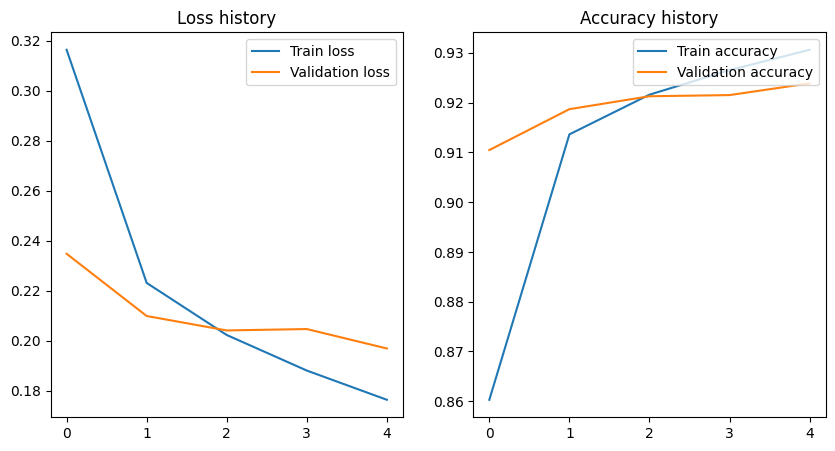

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Loss history')
ax[0].legend(['Train loss', 'Validation loss'],loc='upper right')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Accuracy history')
ax[1].legend(['Train accuracy', 'Validation accuracy'], loc='upper right')

plt.show()

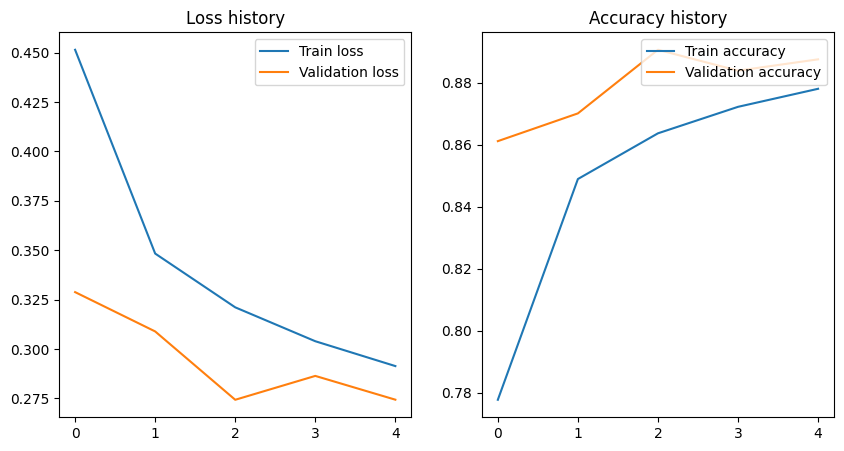

In [279]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Loss history')
ax[0].legend(['Train loss', 'Validation loss'],loc='upper right')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Accuracy history')
ax[1].legend(['Train accuracy', 'Validation accuracy'], loc='upper right')

plt.show()

In [171]:
poi_c2v.save_model('../../data/06_models/Conv-orbis-training-large-Fibonacci-filters')

In [137]:
model = poi_c2v.load_model('../../data/06_models/Conv-mixed-sources-training-BEAT-EDIT-large')

In [58]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_branch_input (InputLayer)  [(None, 100, 1)]    0           []                               
                                                                                                  
 right_branch_input (InputLayer  [(None, 100, 1)]    0           []                               
 )                                                                                                
                                                                                                  
 model (Functional)             (None, 640)          407440      ['left_branch_input[0][0]',      
                                                                  'right_branch_input[0][0]']     
                                                                                            

In [59]:
X_test_1 = encode_sparsed_list(X_test[:, 0],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
X_test_2 = encode_sparsed_list(X_test[:, 1],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)

# X_train_1 = encode_sparsed_list(X_train[:, 0],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
# X_train_2 = encode_sparsed_list(X_train[:, 1],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)

In [60]:
model.predict((X_test_1, X_test_2))

299/299 [==============================] - 5s 16ms/step



array([[6.9816035e-01],
       [2.2602160e-01],
       [6.1700662e-04],
       ...,
       [9.2893755e-01],
       [9.8498392e-01],
       [9.5175618e-01]], dtype=float32)

In [62]:
test_predictions = model.predict((X_test_1, X_test_2))
# train_predictions = poi_c2v.model.predict((X_train_1, X_train_2))

299/299 [==============================] - 5s 16ms/step



(
    array([1551., 1002., 1067.,  987.,  655.,  461.,  264.,  253.,  384.,
       2920.]),
    array([6.48934838e-06, 9.99811962e-02, 1.99955910e-01, 2.99930632e-01,
       3.99905324e-01, 4.99880046e-01, 5.99854767e-01, 6.99829459e-01,
       7.99804151e-01, 8.99778903e-01, 9.99753594e-01]),
    <BarContainer object of 10 artists>
)

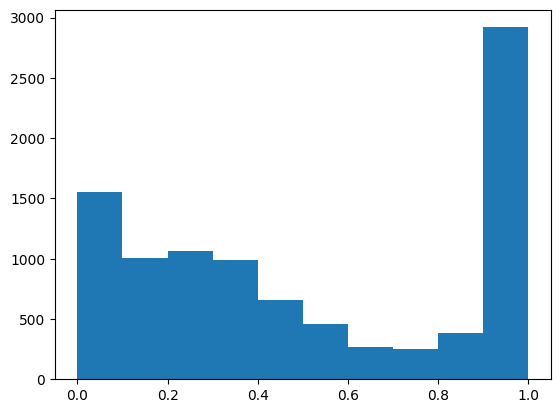

In [63]:
plt.hist(test_predictions)

In [64]:
pd.crosstab((y_test>=.75).flatten(), (test_predictions>=.5).flatten())

col_0,False,True
row_0,,
False,4308,450
True,954,3832


In [65]:
print(classification_report((y_test>=.5).flatten(), (test_predictions>=.5).flatten()))

              precision    recall  f1-score   support

       False       0.82      0.91      0.86      4758
        True       0.89      0.80      0.85      4786

    accuracy                           0.85      9544
   macro avg       0.86      0.85      0.85      9544
weighted avg       0.86      0.85      0.85      9544



In [66]:
from fuzzywuzzy import fuzz

In [67]:
fuzz.token_set_ratio('margaret mead junior', 'mead jr')

73

In [68]:
token_set_predictions = np.array([fuzz.token_set_ratio(name1, name2)/100 for name1, name2 in X_test])
# token_set_predictions_train = np.array([fuzz.token_set_ratio(name1, name2)/100 for name1, name2 in X_train])

In [69]:
pd.crosstab((y_test>=.5).flatten(), token_set_predictions>.75)

col_0,False,True
row_0,,
False,4743,15
True,910,3876


In [70]:
print(classification_report((y_test>=.75).flatten(), token_set_predictions>.75))

              precision    recall  f1-score   support

       False       0.84      1.00      0.91      4758
        True       1.00      0.81      0.89      4786

    accuracy                           0.90      9544
   macro avg       0.92      0.90      0.90      9544
weighted avg       0.92      0.90      0.90      9544



In [62]:
results = pd.DataFrame(X_test)
results['prediction'] = test_predictions>=.5
results['token_set_ratio'] = token_set_predictions
results['label'] = y_test
results.columns = ['name_1', 'name_2', 'prediction','token_set_ratio', 'label']
results['prediction_error'] = results['prediction'] != results['label']
results['edit_error'] = (results['token_set_ratio']>.75) != results['label']

In [63]:
results_train = pd.DataFrame(X_train)
results_train['prediction'] = train_predictions
results_train['token_set_ratio'] = token_set_predictions_train
results_train['label'] = y_train
results_train.columns = ['name_1', 'name_2', 'prediction','token_set_ratio', 'label']
results_train['error'] = (results_train['prediction']>.5).astype(int) != results_train['label'].astype(int)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
│                                                                                                  │
│   1 results_train = pd.DataFrame(X_train)                                                        │
│ ❱ 2 results_train['prediction'] = train_predictions                                              │
│   3 results_train['token_set_ratio'] = token_set_predictions_train                               │
│   4 results_train['label'] = y_train                                                             │
│   5 results_train.columns = ['name_1', 'name_2', 'prediction','token_set_ratio', 'label']        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'train_predictions' is not defined

In [65]:
results.to_csv('conv_results_test_mixed_sources.csv', index=False)
results_train.to_csv('conv_results_train_orbis.csv', index=False)

# 6. Prediciton

In [181]:
standard_1 = np.array(['paseo de la castellana 163 madrid 28017',
                        'dave smith',
                       'international business machine corp',
                       'banca nazionale del lavoro',
                       'massachusets institute of technology',
                       'madrid institue of technology',
                       'banco bilbao vizcaya argentaria',
                       'bill gates',
                       'william h gates',
                       'mary miller',
                       'mary',
                       'ibm inc',
                       'ibm inc', 
                       'dave smith',
                       'royal free hospital',
                       'royal free hospital emergency room',
                       'royal free hospital school of medicine',
                       'howdens joinery',
                      'car craft'])
standard_2 = np.array(['paseo de la castellana 161 madrid 28017',
                        'david smith',
                       'ibm',
                       'bnl',
                       'mit',
                       'mit',
                       'bbva',
                       'william gates',
                       'william a gates',
                       'mark miller',
                       'mark',
                       'ibm corp',
                       'ibs inc',
                       'smith dave',
                       'royal free hospital emergency room',
                       'royal free hospital immunology',
                       'royal free hospital immunology',
                       'howdens new romney',
                      'carcraft and mot service centre'])
standard_target = np.array([1, 1,1,1,0,1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1])
token_set_ratio = [fuzz.token_set_ratio(name1, name2)/100 for name1, name2 in list(zip(standard_1, standard_2))]

In [182]:
standard_1_vectorized = encode_sparsed_list(standard_1,char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
standard_2_vectorized = encode_sparsed_list(standard_2,char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)

In [183]:
standard_predictions = poi_c2v.model.predict((standard_1_vectorized, standard_2_vectorized))

1/1 [==============================] - 0s 37ms/step


In [184]:
pd.DataFrame(list(zip(standard_1, standard_2, standard_target, standard_predictions, token_set_ratio)))

,0,1,2,3,4
0,paseo de la castellana 163 madrid 28017,paseo de la castellana 161 madrid 28017,1,[1.0],0.97
1,dave smith,david smith,1,[0.99995995],0.86
2,international business machine corp,ibm,1,[0.09302089],0.11
3,banca nazionale del lavoro,bnl,1,[0.15652016],0.21
4,massachusets institute of technology,mit,0,[0.13062263],0.10
5,madrid institue of technology,mit,1,[0.20601977],0.12
6,banco bilbao vizcaya argentaria,bbva,1,[0.8531332],0.06
7,bill gates,william gates,0,[0.99979806],0.78
8,william h gates,william a gates,0,[0.9999999],0.93
9,mary miller,mark miller,0,[0.9995703],0.91


In [142]:
pd.DataFrame(list(zip(standard_1, standard_2, standard_target, standard_predictions, token_set_ratio)))

,0,1,2,3,4
0,paseo de la castellana 163 madrid 28017,paseo de la castellana 161 madrid 28017,1,[0.997929],0.97
1,dave smith,david smith,1,[0.998742],0.86
2,international business machine corp,ibm,1,[0.77576053],0.11
3,banca nazionale del lavoro,bnl,1,[0.34571025],0.21
4,massachusets institute of technology,mit,0,[0.5362472],0.10
5,madrid institue of technology,mit,1,[0.5866928],0.12
6,banco bilbao vizcaya argentaria,bbva,1,[0.41756752],0.06
7,bill gates,william gates,0,[0.8190667],0.78
8,william h gates,william a gates,0,[0.9979643],0.93
9,mary miller,mark miller,0,[0.9946093],0.91


In [185]:
geonames_pairs = catalog.load('geonames_latin_pairs')
geonames_pairs = geonames_pairs.withColumn('target', when(col('match') == 'true', 1).otherwise(0).cast(FloatType()))
geonames_pairs_es = geonames_pairs.filter(col('language_1').isin(['ES', 'MX']))
geonames_normalized = geonames_pairs_es.withColumn('name_1_normalized', udf_normalize_chars(col('name_1'))) \
                .withColumn('name_2_normalized', udf_normalize_chars(col('name_2')))


name_pairs = geonames_normalized.select('name_1_normalized', 'name_2_normalized').toPandas().values
target = geonames_normalized.select(col('target')).toPandas().astype(float).values

X1 = encode_sparsed_list(name_pairs[:, 0],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
X2 = encode_sparsed_list(name_pairs[:, 1],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)

[08/22/23 23:04:37] INFO     Loading data from 'geonames_latin_pairs' (SparkDataSet)...         ]8;id=947467;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=992668;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

In [186]:
geonames_predictions = poi_c2v.model.predict((X1, X2))

1708/1708 [==============================] - 35s 20ms/step



(
    array([13908.,  4153.,  1894.,  1129.,   833.,   632.,   638.,   800.,
        1228., 29428.]),
    array([1.33566091e-05, 1.00012019e-01, 2.00010687e-01, 3.00009340e-01,
       4.00008023e-01, 5.00006676e-01, 6.00005329e-01, 7.00003982e-01,
       8.00002694e-01, 9.00001347e-01, 1.00000000e+00]),
    <BarContainer object of 10 artists>
)

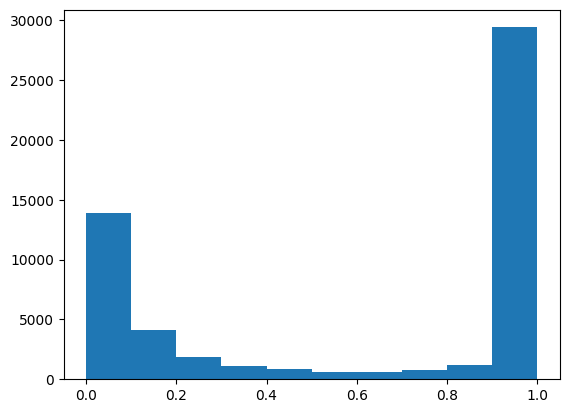

In [187]:
plt.hist(geonames_predictions)

In [188]:
pd.crosstab((target>=.75).flatten(), (geonames_predictions>=.5).flatten())

col_0,False,True
row_0,,
False,17786,9615
True,4131,23111


In [189]:
print(classification_report((target>=.5).flatten(), geonames_predictions>.5))

              precision    recall  f1-score   support

       False       0.81      0.65      0.72     27401
        True       0.71      0.85      0.77     27242

    accuracy                           0.75     54643
   macro avg       0.76      0.75      0.75     54643
weighted avg       0.76      0.75      0.75     54643



In [190]:

token_set_predictions = np.array([fuzz.token_set_ratio(name1, name2)/100 for name1, name2 in name_pairs])>.75
pd.crosstab((target>=.5).flatten(), token_set_predictions)

col_0,False,True
row_0,,
False,23164,4237
True,7350,19892


In [191]:
print(classification_report((target>=.5).flatten(), token_set_predictions))

              precision    recall  f1-score   support

       False       0.76      0.85      0.80     27401
        True       0.82      0.73      0.77     27242

    accuracy                           0.79     54643
   macro avg       0.79      0.79      0.79     54643
weighted avg       0.79      0.79      0.79     54643



# Match logs comparison

In [192]:
matching_logs = pd.read_csv('../../data/01_raw/tomtom/full_matching_logs_ES_EN_ov32.csv')

In [193]:
matching_logs.columns


Index(['release_version', 'enduser_category', 'category_id_tt',
       'category_name', 'reference_translated_cat_id', 'reference_id',
       'api_poi_id', 'providers_translated_cat_id', 'ref_lat', 'ref_lon',
       'location_distance_m', 'pav_threshold_distance_m',
       'pa_threshold_distance_m', 'name', 'api_poiName', 'name_ref_nrm',
       'name_prov_nrm', 'api_poiBrand', 'brand_flag', 'category_matching',
       'distance_matching', 'name_matching', 'match_code', 'match',
       'best_result', 'bool_pa', 'config_params', 'region', 'matching_run_id',
       'provider_id', 'country', 'sample_round'],
      dtype='object')

In [194]:
matching_names = matching_logs.copy()

In [195]:
matching_names['name'] = matching_names['name'].apply(lambda x: normalize_characters(x))
matching_names['api_poiName'] = matching_names['api_poiName'].apply(lambda x: normalize_characters(x))

In [196]:
matching_names = matching_names[(~matching_names['name_matching'].isnull()) & (matching_names['api_poiName']!= 'null') & (matching_names['match_code'] != 5)]

In [197]:
matching_names

,release_version,enduser_category,category_id_tt,category_name,reference_translated_cat_id,reference_id,api_poi_id,providers_translated_cat_id,ref_lat,ref_lon,...,match_code,match,best_result,bool_pa,config_params,region,matching_run_id,provider_id,country,sample_round
2,23320.000 OV,Automotive,9910,Automotive Dealer,9910,ChIJ3W8E5CrBz4URipUCDSXmFhA,3.393684e+10,7310.0,19.054592,-98.219340,...,2,False,True,NaN,NaN,NaN,20230814-06094864,om,MEX,cc
3,23320.000 OV,Eat & Drink,9376,Café/Pub,9376,ChIJ54VcVHuK2YURvKEcmE-C290,3.398599e+10,7315.0,20.945530,-97.389084,...,1,True,True,True,NaN,NaN,20230814-06094864,om,MEX,cc
5,23320.000 OV,Things to see & do,9357,Beach,9357,ChIJH7DqZYr414URTUf3jjOCJXw,1.021585e+10,9357.0,22.290174,-97.803566,...,1,True,True,False,NaN,NaN,20230814-06094864,om,MEX,cc
11,23320.000 OV,Eat & Drink,9376,Café/Pub,9376,ChIJVxwysZvELIQRpNPc9kU8Z_0,3.400459e+10,7315.0,20.213703,-100.882120,...,2,False,True,NaN,NaN,NaN,20230814-06094864,om,MEX,cc
12,23320.000 OV,Automotive,9910,Automotive Dealer,9910,ChIJX7BDM4DAK4QRkX7UT6vS8lw,3.395777e+10,9910.0,21.117882,-101.707825,...,1,True,True,True,NaN,NaN,20230814-06094864,om,MEX,cc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19518,23320.000 OV,Things to see & do,9362,Park and Recreation Area,9362,ChIJW-KdHvNGIYQRMqixIdx1U60,1.053229e+10,9362.0,20.714619,-105.274820,...,1,True,True,True,NaN,NaN,20230814-06094864,om,MEX,cc
19523,23320.000 OV,Amenities,7328,Bank,7328,ChIJ2aMAqttpNg0RVxngOC1-VWo,3.392415e+10,7328.0,43.358700,-5.506369,...,1,True,True,True,NaN,NaN,20230814-06094864,om,ESP,cc
19526,23320.000 OV,Lodging,7360,Camping Ground,7360,ChIJNwJYS9N9MQ0RR5FIbDmEiYs,3.398923e+10,7360.0,43.545910,-6.995946,...,1,True,True,True,NaN,NaN,20230814-06094864,om,ESP,cc
19532,23320.000 OV,Things to see & do,9357,Beach,9357,ChIJgyIbeDyruxIRKTnr1nkabJ0,7.324229e+09,8099.0,41.861630,3.150960,...,1,True,True,False,NaN,NaN,20230814-06094864,om,ESP,cc


In [285]:
matching_test_names = matching_names[['name_ref_nrm', 'name_prov_nrm']].values

In [286]:
matching_test_names_encoded_left = encode_sparsed_list(matching_test_names[:, 0],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
matching_test_names_encoded_right = encode_sparsed_list(matching_test_names[:, 1],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)

In [287]:
matching_test_names_prediction = poi_c2v.model.predict((matching_test_names_encoded_left, matching_test_names_encoded_right))

323/323 [==============================] - 7s 21ms/step


In [288]:
matching_names['cnn_name_match_score'] = matching_test_names_prediction

In [289]:
matching_names['edit_distance_match'] = matching_names['name_matching']>=0.75
matching_names['cnn_match'] = matching_names['cnn_name_match_score']>=0.5

In [290]:
pd.crosstab(matching_names['edit_distance_match'], matching_names['cnn_match'])

cnn_match,False,True
edit_distance_match,,
False,194,14
True,28,10077


In [291]:
matching_names[['category_name', 'name', 'api_poiName','api_poiBrand', 'name_ref_nrm', 'name_prov_nrm', 'location_distance_m', 'match','match_code', 'cnn_match', 'edit_distance_match', 'name_matching', 'cnn_name_match_score']].to_csv('name_matching_comparison_cnn_vs_edit.csv', index=False)


(
    array([1.800e+02, 1.400e+01, 1.300e+01, 6.000e+00, 9.000e+00, 1.200e+01,
       2.200e+01, 3.200e+01, 4.700e+01, 9.978e+03]),
    array([1.30743347e-05, 1.00011766e-01, 2.00010464e-01, 3.00009161e-01,
       4.00007844e-01, 5.00006557e-01, 6.00005209e-01, 7.00003922e-01,
       8.00002635e-01, 9.00001287e-01, 1.00000000e+00]),
    <BarContainer object of 10 artists>
)

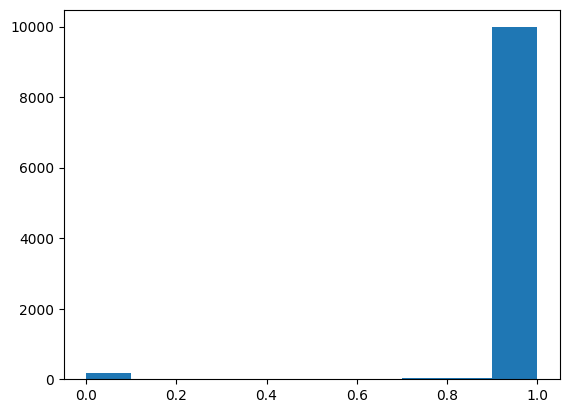

In [292]:
plt.hist(matching_test_names_prediction)

# Orbis data comparison

In [257]:
orbis_data = pd.read_csv('../../data/01_raw/tomtom/orbis/alt_names/FR/planet_osm_point_202308231233.csv')
orbis_data['name'] = orbis_data['name'].apply(lambda x: normalize_characters(x))
orbis_data['alt_name'] = orbis_data['alt_name'].apply(lambda x: normalize_characters(x))
orbis_data['target'] = 1

pos_name_pairs = orbis_data[['name', 'alt_name']].values
neg_name_pairs = orbis_data[['name', 'alt_name']].values.copy()
pos_target = orbis_data['target'].values
neg_target = np.zeros(len(neg_name_pairs))

np.random.shuffle(neg_name_pairs[:, 0])

name_pairs_orbis = np.concatenate((neg_name_pairs, pos_name_pairs))
target_orbis = np.concatenate((neg_target, pos_target))

In [261]:
def generate_comparison_model_vs_edit(pairs, target, match_th, ):
    X_encoded_1 = encode_sparsed_list(pairs[:, 0],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
    X_encoded_2 = encode_sparsed_list(pairs[:, 1],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
    
    prediction = poi_c2v.model.predict((X_encoded_1, X_encoded_2))
    prediction_edit = np.array([fuzz.token_set_ratio(name1, name2)/100 for name1, name2 in pairs])
    
    y_pred = prediction>=match_th
    y_pred = y_pred.flatten()
    y_pred_edit = prediction_edit>=.75
    y_pred_edit = y_pred_edit.flatten()
    target = target.astype(np.bool).flatten()

    
    print('confussion matrix model')
    print(pd.crosstab(target, y_pred))
    print('\n confussion matrix edit')
    print(pd.crosstab(target, y_pred_edit))
    
    print('/n/n Classification report model')
    print(classification_report((target>=.5).flatten(), y_pred))
    print('/n Classification report edit')
    print(classification_report((target>=.5).flatten(), y_pred_edit))

    df_prediction = pd.DataFrame(list(zip(pairs[:, 0], pairs[:, 1], prediction, prediction_edit, target, y_pred, y_pred_edit)))
    df_prediction.columns = ['name_1', 'name_2', 'prediction_model', 'prediction_edit', 'target', 'match_model', 'match_edit']
    return df_prediction

In [265]:
result = generate_comparison_model_vs_edit(name_pairs_orbis, target_orbis, 0.75)

3125/3125 [==============================] - 67s 21ms/step


[08/23/23 10:46:51] WARNING  /tmp/ipykernel_1915/2792745085.py:12: DeprecationWarning: `np.bool` is ]8;id=134011;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=499949;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             a deprecated alias for the builtin `bool`. To silence this warning,                   
                             use `bool` by itself. Doing this will not modify any behavior and is                  
                             safe. If you specifically wanted the numpy scalar type, use `np.bool_`                
                             here.                                                                                 
                             Deprecated in NumPy 1.20; for more details and guidance:                              
                             https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations                      
                               target = target.astype(np.bool).flatten()                                           
                                                                                                                   

confussion matrix model
col_0  False  True 
row_0              
False  49235    765
True    3060  46940

 confussion matrix edit
col_0  False  True 
row_0              
False  49798    202
True    5971  44029
/n/n Classification report model
              precision    recall  f1-score   support

       False       0.94      0.98      0.96     50000
        True       0.98      0.94      0.96     50000

    accuracy                           0.96    100000
   macro avg       0.96      0.96      0.96    100000
weighted avg       0.96      0.96      0.96    100000

/n Classification report edit
              precision    recall  f1-score   support

       False       0.89      1.00      0.94     50000
        True       1.00      0.88      0.93     50000

    accuracy                           0.94    100000
   macro avg       0.94      0.94      0.94    100000
weighted avg       0.94      0.94      0.94    100000



In [266]:
result.to_csv('orbis_prediction_FR.csv', index=False)

# Dataset gold standard

In [233]:
data_standard = pd.read_csv('../../data/02_intermediate/names/names.csv')

In [234]:
data_standard['name_1'] = data_standard['name_1'].apply(lambda x: normalize_characters(x))
data_standard['name_2'] = data_standard['name_2'].apply(lambda x: normalize_characters(x))

In [235]:
data_standard_pairs = data_standard[['name_1', 'name_2']].values
data_standard_target = data_standard['target'].values

In [236]:
generate_comparison_model_vs_edit(data_standard_pairs, data_standard_target, .5)

255/255 [==============================] - 5s 20ms/step


[08/23/23 10:27:21] WARNING  /tmp/ipykernel_1915/886421279.py:12: DeprecationWarning: `np.bool` is  ]8;id=261833;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=389594;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             a deprecated alias for the builtin `bool`. To silence this warning,                   
                             use `bool` by itself. Doing this will not modify any behavior and is                  
                             safe. If you specifically wanted the numpy scalar type, use `np.bool_`                
                             here.                                                                                 
                             Deprecated in NumPy 1.20; for more details and guidance:                              
                             https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations                      
                               target = target.astype(np.bool).flatten()                                           
                                                                                                                   

confussion matrix model
col_0  False  True 
row_0              
False    822   3045
True      45   4248

 confussion matrix edit
col_0  False  True 
row_0              
False   1617   2250
True     763   3530
/n/n Classification report model
              precision    recall  f1-score   support

       False       0.95      0.21      0.35      3867
        True       0.58      0.99      0.73      4293

    accuracy                           0.62      8160
   macro avg       0.77      0.60      0.54      8160
weighted avg       0.76      0.62      0.55      8160

/n Classification report edit
              precision    recall  f1-score   support

       False       0.68      0.42      0.52      3867
        True       0.61      0.82      0.70      4293

    accuracy                           0.63      8160
   macro avg       0.65      0.62      0.61      8160
weighted avg       0.64      0.63      0.61      8160



,name_1,name_2,prediction_model,prediction_edit,target,match_model,match_edit
0,21st century insurance group,21st century insurace,[0.99997616],0.86,True,True,True
1,3com corporation,marco corporation,[0.98433185],0.85,False,True,True
2,3com corporation,mm corporation,[0.99801904],0.88,False,True,True
3,3com corporation,ramcon corporation,[0.9897918],0.82,False,True,True
4,a and w office supply,sandia office supply,[0.99730307],0.83,False,True,True
...,...,...,...,...,...,...,...
8155,carnegie mellon,carnigie mellon carnagie mellon,[0.99340785],0.72,True,True,False
8156,nonoperational,unoperational,[0.99992114],0.89,True,True,True
8157,skating,skateing,[0.99981946],0.93,True,True,True
8158,habsburg,habsbourg,[0.9986739],0.94,True,True,True


## Amazon products evaluation

In [237]:
data_prod= pd.read_csv('../../data/01_raw/amazon-google-products/mapping_full.csv')

In [238]:
data_prod['name_1'] = data_prod['name_1'].apply(lambda x: normalize_characters(x))
data_prod['name_2'] = data_prod['name_2'].apply(lambda x: normalize_characters(x))
data_prod['target'] = 1


In [239]:
data_prod_pairs = data_prod[['name_1', 'name_2']].values
data_prod_target = data_prod['target'].values

In [240]:
generate_comparison_model_vs_edit(data_prod_pairs, data_prod_target, .75)

41/41 [==============================] - 1s 20ms/step


[08/23/23 10:29:02] WARNING  /tmp/ipykernel_1915/886421279.py:12: DeprecationWarning: `np.bool` is  ]8;id=839663;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=790079;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             a deprecated alias for the builtin `bool`. To silence this warning,                   
                             use `bool` by itself. Doing this will not modify any behavior and is                  
                             safe. If you specifically wanted the numpy scalar type, use `np.bool_`                
                             here.                                                                                 
                             Deprecated in NumPy 1.20; for more details and guidance:                              
                             https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations                      
                               target = target.astype(np.bool).flatten()                                           
                                                                                                                   

confussion matrix model
col_0  False  True 
row_0              
True      12   1288

 confussion matrix edit
col_0  False  True 
row_0              
True     198   1102
/n/n Classification report model


                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=902732;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=195016;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=648703;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=628791;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=954781;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=390572;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.99      1.00      1300

    accuracy                           0.99      1300
   macro avg       0.50      0.50      0.50      1300
weighted avg       1.00      0.99      1.00      1300

/n Classification report edit


                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=240490;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=742298;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=907371;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=406504;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=211283;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=701847;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.85      0.92      1300

    accuracy                           0.85      1300
   macro avg       0.50      0.42      0.46      1300
weighted avg       1.00      0.85      0.92      1300



,name_1,name_2,prediction_model,prediction_edit,target,match_model,match_edit
0,clickart 950 000 premier image pack dvd rom,clickart 950000 premier image pack dvd rom,[1.0],0.94,True,True,True
1,noahs ark activity center jewel case ages 3 8,the beginners bible noahs ark activity center ...,[0.99957424],0.73,True,True,False
2,peachtree by sage premium accounting for nonpr...,sage ptree vernfp2007rt premium accounting for...,[1.0],0.87,True,True,True
3,singing coach unlimited,singing coach unlimited electronic learning pr...,[0.99999684],1.00,True,True,True
4,adobe after effects professional 6 5 upgrade f...,adobe software 22070152 after effects 6 5 pbupgrd,[0.9999811],0.64,True,True,False
...,...,...,...,...,...,...,...
1295,shapes,school zone interactive shapes on track software,[0.99745786],1.00,True,True,True
1296,dragon naturally speaking standard v9,nuance communications inc dragon ns standard v9,[0.9898438],0.65,True,True,False
1297,mediarecover,allume systems inc mediarecover,[0.99980617],1.00,True,True,True
1298,mediarecover,allume mediarecover,[0.9999321],1.00,True,True,True


# ABT vs BUY products evaluation

In [241]:
data_prod_abt = pd.read_csv('../../data/01_raw/abt-buy-dataset/abt_buy_perfectMapping_full.csv')

In [242]:
data_prod_abt['name_1'] = data_prod_abt['name_1'].apply(lambda x: normalize_characters(x))
data_prod_abt['name_2'] = data_prod_abt['name_2'].apply(lambda x: normalize_characters(x))
data_prod_abt['target'] = 1

In [243]:
data_prod_abt_pairs = data_prod_abt[['name_1', 'name_2']].values
data_prod_abt_target = data_prod_abt['target'].values

In [244]:
data_prod_abt_pairs


array([['linksys etherfast 8 port 10 100 switch ezxs88w',
        'linksys etherfast ezxs88w ethernet switch ezxs88w'],
       ['linksys etherfast10 100 5 port auto sensing switch ezxs55w',
        'linksys etherfast ezxs55w ethernet switch'],
       ['netgear prosafe 5 port 10 100 desktop switch fs105',
        'netgear prosafe fs105 ethernet switch fs105na'],
       ...,
       ['sony lcs twa b black soft leather carrying case lcstwab',
        'sony lcs twa b cyber shot camera case lcstwa b'],
       ['sony white cybershot t series digital camera jacket case with stylus lcjthcw',
        'sony lcj thc b jacket case with stylus lcj thc w'],
       ['sony lcs csj black soft carrying case lcscsj',
        'sony lcs csj soft camera case lcscsj']], dtype=object)

In [245]:
generate_comparison_model_vs_edit(data_prod_abt_pairs, data_prod_abt_target, .5)

35/35 [==============================] - 1s 20ms/step


[08/23/23 10:29:16] WARNING  /tmp/ipykernel_1915/886421279.py:12: DeprecationWarning: `np.bool` is  ]8;id=461034;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=724670;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             a deprecated alias for the builtin `bool`. To silence this warning,                   
                             use `bool` by itself. Doing this will not modify any behavior and is                  
                             safe. If you specifically wanted the numpy scalar type, use `np.bool_`                
                             here.                                                                                 
                             Deprecated in NumPy 1.20; for more details and guidance:                              
                             https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations                      
                               target = target.astype(np.bool).flatten()                                           
                                                                                                                   

confussion matrix model
col_0  False  True 
row_0              
True       3   1094

 confussion matrix edit
col_0  False  True 
row_0              
True     327    770
/n/n Classification report model


                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=418578;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=367377;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=659269;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=662481;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=930621;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=873262;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      1.00      1.00      1097

    accuracy                           1.00      1097
   macro avg       0.50      0.50      0.50      1097
weighted avg       1.00      1.00      1.00      1097

/n Classification report edit


                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=776504;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=60274;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=40271;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=350586;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=343341;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=563181;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.70      0.82      1097

    accuracy                           0.70      1097
   macro avg       0.50      0.35      0.41      1097
weighted avg       1.00      0.70      0.82      1097



,name_1,name_2,prediction_model,prediction_edit,target,match_model,match_edit
0,linksys etherfast 8 port 10 100 switch ezxs88w,linksys etherfast ezxs88w ethernet switch ezxs88w,[0.99999994],0.88,True,True,True
1,linksys etherfast10 100 5 port auto sensing sw...,linksys etherfast ezxs55w ethernet switch,[1.0],0.71,True,True,False
2,netgear prosafe 5 port 10 100 desktop switch f...,netgear prosafe fs105 ethernet switch fs105na,[1.0],0.77,True,True,True
3,belkin f3h982 10 pro series high integrity 10 ...,belkin pro series high integrity vga svga moni...,[1.0],0.89,True,True,True
4,netgear prosafe 16 port 10 100 rackmount switc...,netgear prosafe jfs516 ethernet switch,[1.0],0.73,True,True,False
...,...,...,...,...,...,...,...
1092,audiovox xpressr xm satellite radio receiver x...,audiovox xpress r xm radio receiver with vehic...,[1.0],0.80,True,True,True
1093,sony lcs twa r red soft leather carrying case ...,sony lcs twa r cyber shot camera case,[0.97329795],0.68,True,True,False
1094,sony lcs twa b black soft leather carrying cas...,sony lcs twa b cyber shot camera case lcstwa b,[0.9988861],0.71,True,True,False
1095,sony white cybershot t series digital camera j...,sony lcj thc b jacket case with stylus lcj thc w,[0.9999943],0.82,True,True,True


# Affiliations dataset

In [246]:
raw_names = pd.read_csv('../../data/01_raw/affiliations/affiliationstrings_ids.csv')
mapping = pd.read_csv('../../data/01_raw/affiliations/affiliationstrings_mapping.csv').astype('int')

In [247]:
mapping.columns = ['id1', 'id2']
raw_names.columns = ['id', 'name']

In [248]:
data_affiliations = mapping.merge(raw_names, left_on='id1', right_on='id').merge(raw_names, left_on='id2', right_on='id')

In [249]:
data_affiliations['name_x'] = data_affiliations['name_x'].apply(lambda x: normalize_characters(x))
data_affiliations['name_y'] = data_affiliations['name_y'].apply(lambda x: normalize_characters(x))
data_affiliations['target'] = 1

In [250]:
data_affiliations = data_affiliations.drop_duplicates(subset=['name_x', 'name_y'])

In [251]:
data_affiliations_pairs = data_affiliations[['name_x', 'name_y']].values
data_affiliations_target = data_affiliations['target'].values

In [252]:
X_encoded_1 = encode_sparsed_list(data_affiliations_pairs[:, 0],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
X_encoded_2 = encode_sparsed_list(data_affiliations_pairs[:, 1],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
    
prediction = poi_c2v.model.predict((X_encoded_1, X_encoded_2))

145/863 [====>.........................] - ETA: 14s

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 4>:4                                                                              │
│                                                                                                  │
│   1 X_encoded_1 = encode_sparsed_list(data_affiliations_pairs[:, 0],char_to_index_dict=char_     │
│   2 X_encoded_2 = encode_sparsed_list(data_affiliations_pairs[:, 1],char_to_index_dict=char_     │
│   3                                                                                              │
│ ❱ 4 prediction = poi_c2v.model.predict((X_encoded_1, X_encoded_2))                               │
│   5                                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py:65 in error_handler        │
│                                                                                                  │
│    62 │   │                                                                                      │
│    63 │   │   filtered_tb = None                                                                 │
│    64 │   │   try:                                                                               │
│ ❱  65 │   │   │   return fn(*args, **kwargs)                                                     │
│    66 │   │   except Exception as e:                                                             │
│    67 │   │   │   filtered_tb = _process_traceback_frames(e.__traceback__)                       │
│    68 │   │   │   # To get the full stack trace, call:                                           │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:2350 in predict                  │
│                                                                                                  │
│   2347 │   │   │   │   with data_handler.catch_stop_iteration():                                 │
│   2348 │   │   │   │   │   for step in data_handler.steps():                                     │
│   2349 │   │   │   │   │   │   callbacks.on_predict_batch_begin(step)                            │
│ ❱ 2350 │   │   │   │   │   │   tmp_batch_outputs = self.predict_function(iterator)               │
│   2351 │   │   │   │   │   │   if data_handler.should_sync:                                      │
│   2352 │   │   │   │   │   │   │   context.async_wait()                                          │
│   2353 │   │   │   │   │   │   batch_outputs = (                                                 │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/tensorflow/python/util/traceback_utils.py:150 in          │
│ error_handler                                                                                    │
│                                                                                                  │
│   147 │                                                                                          │
│   148 │   filtered_tb = None                                                                     │
│   149 │   try:                                                                                   │
│ ❱ 150 │     return fn(*args, **kwargs)                                                           │
│   151 │   except Exception as e:                                                                 │
│   152 │     filtered_tb = _process_traceback_frames(e.__traceback__)                             │
│   153 │     raise e.with_traceback(filtered_tb) from None                                        │
│                                                            

In [253]:
prediction_token_set = np.array([fuzz.token_set_ratio(name1, name2)/100 for name1, name2 in data_affiliations_pairs])

In [254]:
data_affiliations['cnn_prediction'] = prediction.flatten()
data_affiliations['token_set_prediction'] = prediction_token_set

data_affiliations['cnn_match'] = prediction>.5
data_affiliations['token_set_match'] = prediction_token_set>.75

In [255]:
data_affiliations.to_csv('affiliations_cnn_vs_edit_predictions.csv', index=False)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ ❱ 1 data_affiliations.to_csv('affiliations_cnn_vs_edit_predictions.csv', index=False)            │
│   2                                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/pandas/util/_decorators.py:211 in wrapper                 │
│                                                                                                  │
│   208 │   │   │   │   │   raise TypeError(msg)                                                   │
│   209 │   │   │   │   else:                                                                      │
│   210 │   │   │   │   │   kwargs[new_arg_name] = new_arg_value                                   │
│ ❱ 211 │   │   │   return func(*args, **kwargs)                                                   │
│   212 │   │                                                                                      │
│   213 │   │   return cast(F, wrapper)                                                            │
│   214                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/pandas/core/generic.py:3720 in to_csv                     │
│                                                                                                  │
│    3717 │   │   │   decimal=decimal,                                                             │
│    3718 │   │   )                                                                                │
│    3719 │   │                                                                                    │
│ ❱  3720 │   │   return DataFrameRenderer(formatter).to_csv(                                      │
│    3721 │   │   │   path_or_buf,                                                                 │
│    3722 │   │   │   lineterminator=lineterminator,                                               │
│    3723 │   │   │   sep=sep,                                                                     │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/pandas/util/_decorators.py:211 in wrapper                 │
│                                                                                                  │
│   208 │   │   │   │   │   raise TypeError(msg)                                                   │
│   209 │   │   │   │   else:                                                                      │
│   210 │   │   │   │   │   kwargs[new_arg_name] = new_arg_value                                   │
│ ❱ 211 │   │   │   return func(*args, **kwargs)                                                   │
│   212 │   │                                                                                      │
│   213 │   │   return cast(F, wrapper)                                                            │
│   214                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/pandas/io/formats/format.py:1189 in to_csv                │
│                                                                                                  │
│   1186 │   │   │   storage_options=storage_options,                                              │
│   1187 │   │   │   formatter=self.fmt,                     

In [256]:
generate_comparison_model_vs_edit(data_affiliations_pairs, data_affiliations_target, .75)

863/863 [==============================] - 17s 20ms/step


[08/23/23 10:30:04] WARNING  /tmp/ipykernel_1915/886421279.py:12: DeprecationWarning: `np.bool` is  ]8;id=749807;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=879787;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             a deprecated alias for the builtin `bool`. To silence this warning,                   
                             use `bool` by itself. Doing this will not modify any behavior and is                  
                             safe. If you specifically wanted the numpy scalar type, use `np.bool_`                
                             here.                                                                                 
                             Deprecated in NumPy 1.20; for more details and guidance:                              
                             https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations                      
                               target = target.astype(np.bool).flatten()                                           
                                                                                                                   

confussion matrix model
col_0  False  True 
row_0              
True    3402  24214

 confussion matrix edit
col_0  False  True 
row_0              
True    7684  19932
/n/n Classification report model


                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=477325;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=246938;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=36337;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=673018;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=448259;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=263411;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.88      0.93     27616

    accuracy                           0.88     27616
   macro avg       0.50      0.44      0.47     27616
weighted avg       1.00      0.88      0.93     27616

/n Classification report edit


                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=837830;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=335698;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=958301;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=471848;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification ]8;id=279631;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=224798;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             .py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined                  
                             and being set to 0.0 in labels with no true samples. Use                              
                             `zero_division` parameter to control this behavior.                                   
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.72      0.84     27616

    accuracy                           0.72     27616
   macro avg       0.50      0.36      0.42     27616
weighted avg       1.00      0.72      0.84     27616



,name_1,name_2,prediction_model,prediction_edit,target,match_model,match_edit
0,ibm almaden research center 650 harry road ca ...,almaden research center san jose ca usa,[1.0],1.00,True,True,True
1,almaden,almaden research center san jose ca usa,[0.93908453],1.00,True,True,True
2,cs storage systems dept ibm almaden research c...,almaden research center san jose ca usa,[0.9975686],0.74,True,True,False
3,ibm almaden,almaden research center san jose ca usa,[0.065314114],0.78,True,False,True
4,ibm almaden rc san jose ca,almaden research center san jose ca usa,[0.9982076],0.84,True,True,True
...,...,...,...,...,...,...,...
27611,york university 4700 keele street toronto onta...,york university,[0.9997733],1.00,True,True,True
27612,york university canada,york university,[0.99964315],1.00,True,True,True
27613,york university toronto on canada,york university,[0.9998478],1.00,True,True,True
27614,zhejiang university china china,department of computer science zhejiang univer...,[0.99999976],1.00,True,True,True


# Voters North Carolina

In [1106]:
voters_raw_1 = pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_1000000_modrec_2_ocp_20_myp_0_nump_5.csv')
voters_raw_2 = pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_1000000_modrec_2_ocp_20_myp_1_nump_5.csv')
voters_raw_3 = pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_1000000_modrec_2_ocp_20_myp_2_nump_5.csv')
voters_raw_4 = pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_1000000_modrec_2_ocp_20_myp_3_nump_5.csv')
voters_raw_5 = pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_1000000_modrec_2_ocp_20_myp_4_nump_5.csv')

[08/15/23 20:44:56] WARNING  /tmp/ipykernel_26880/3995391869.py:1: DtypeWarning: Columns (4) have   ]8;id=863690;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=364802;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             mixed types. Specify dtype option on import or set low_memory=False.                  
                               voters_raw_1 =                                                                      
                             pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_10000                
                             00_modrec_2_ocp_20_myp_0_nump_5.csv')                                                 
                                                                                                                   

                    WARNING  /tmp/ipykernel_26880/3995391869.py:2: DtypeWarning: Columns (4) have   ]8;id=597558;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=764248;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             mixed types. Specify dtype option on import or set low_memory=False.                  
                               voters_raw_2 =                                                                      
                             pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_10000                
                             00_modrec_2_ocp_20_myp_1_nump_5.csv')                                                 
                                                                                                                   

[08/15/23 20:44:57] WARNING  /tmp/ipykernel_26880/3995391869.py:3: DtypeWarning: Columns (4) have   ]8;id=135609;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=84305;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             mixed types. Specify dtype option on import or set low_memory=False.                  
                               voters_raw_3 =                                                                      
                             pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_10000                
                             00_modrec_2_ocp_20_myp_2_nump_5.csv')                                                 
                                                                                                                   

                    WARNING  /tmp/ipykernel_26880/3995391869.py:4: DtypeWarning: Columns (4) have   ]8;id=99010;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=610317;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             mixed types. Specify dtype option on import or set low_memory=False.                  
                               voters_raw_4 =                                                                      
                             pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_10000                
                             00_modrec_2_ocp_20_myp_3_nump_5.csv')                                                 
                                                                                                                   

[08/15/23 20:44:58] WARNING  /tmp/ipykernel_26880/3995391869.py:5: DtypeWarning: Columns (4) have   ]8;id=189391;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=269717;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             mixed types. Specify dtype option on import or set low_memory=False.                  
                               voters_raw_5 =                                                                      
                             pd.read_csv('../../data/01_raw/voters_north_carolina/ncvr_numrec_10000                
                             00_modrec_2_ocp_20_myp_4_nump_5.csv')                                                 
                                                                                                                   

In [1121]:
voters_raw_full = pd.concat([voters_raw_1, voters_raw_2, voters_raw_3, voters_raw_4, voters_raw_5])

In [1133]:
voters_raw_full[voters_raw_full.recid == 58253]

,recid,givenname,surname,suburb,postcode
848117,58253,dullie,moss,charlotte,28269.0


In [1132]:
voters_raw_full[voters_raw_full.recid == 185780]

,recid,givenname,surname,suburb,postcode
88045,185780,ida,watts,carrboro,27510


In [1115]:
voters_raw_full.recid.value_counts()[voters_raw_full.recid.value_counts() == 2]


4829629    2
1802971    2
1615979    2
8026477    2
536452     2
          ..
5237754    2
4857586    2
1667198    2
3782787    2
893276     2
Name: recid, Length: 83904, dtype: int64

In [1102]:
voters_raw_1['name'] = voters_raw_1['givenname'] + ' ' + voters_raw_1['surname']
voters_raw_2['name'] = voters_raw_2['givenname'] + ' ' + voters_raw_2['surname']
voters_raw_3['name'] = voters_raw_3['givenname'] + ' ' + voters_raw_3['surname']


In [1105]:
voters_raw_1.merge(voters_raw_2, on='recid', how='left').merge(voters_raw_3, on='recid', how='left').dropna()

,recid,givenname_x,surname_x,suburb_x,postcode_x,name_x,givenname_y,surname_y,suburb_y,postcode_y,name_y,givenname,surname,suburb,postcode,name
1,3138435,ronel,carter,washington,2788g,ronel carter,ronnel,carter,washington,27889.0,ronnel carter,ronnel,carter,washington,27889.0,ronnel carter
2,6117295,jason,roehrig,millers ceeek,286s1,jason roehrig,jason,roehrig,millers creek,28651.0,jason roehrig,jason,roehrig,millers creek,28651.0,jason roehrig
3,6401695,antrea,mure,greensboro,27410,antrea mure,andrea,moore,greensboro,27410.0,andrea moore,andrea,moore,greensboro,27410.0,andrea moore
5,4338459,jonn,snyder,louisbuahg,27549,jonn snyder,john,snyddr,louisburg,27s49,john snyddr,zohn,snyder,louiburg,27549,zohn snyder
6,795481,charie,lyles,sdate road,28676,charie lyles,charlie,lyles,state road,28676.0,charlie lyles,charlie,lyles,state road,28676.0,charlie lyles
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999985,5819868,meagan,pruitt,roxboro,27574.0,meagan pruitt,meagsn,pruiatt,roxboro,27574,meagsn pruiatt,mesgan,pruitt,roxboro,2757q,mesgan pruitt
999989,6680655,justin,pence,greensboro,27407.0,justin pence,justin,pence,greensboro,27407.0,justin pence,justin,pence,greensboro,27407.0,justin pence
999991,517540,roger,fristoe,greensboro,27408.0,roger fristoe,rojyr,fristoe,greensnoro,27408,rojyr fristoe,roger,fristoe,greensboro,27408.0,roger fristoe
999995,6614741,virginia,angle,charlotte,28205.0,virginia angle,virginia,angle,charlotte,28205.0,virginia angle,virginia,angle,charlotte,28205.0,virginia angle


# Embedding analysis

In [148]:

poi_c2v = poiNames_C2V(150, char_to_index)
poi_c2v = poi_c2v.load_model('../../data/06_models/Conv-mixed-sources-training-BEAT-EDIT')

In [160]:
test_names = ['ibm', 'international business machines']

In [161]:
X = encode_sparsed_list(test_names,char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)

In [163]:
test_names

['ibm', 'international business machines']

In [162]:
print(X)

[[20. 13. 24.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [20. 25. 31. 16. 29. 25. 12. 31. 20. 26. 25. 12. 23.  1. 13. 32. 30. 20.
  25. 16. 30. 30.  1. 24. 12. 14. 19. 20. 25. 16. 30.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


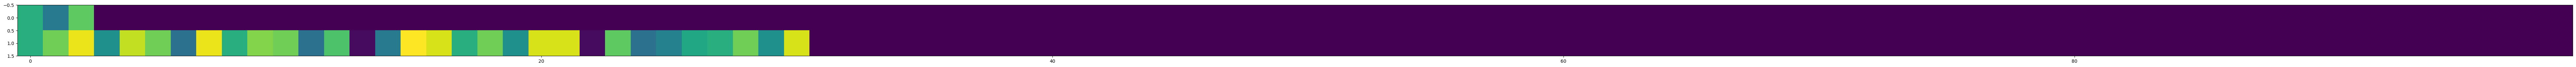

In [164]:
plt.figure(figsize=(100,100))
plt.imshow(X[:2])

1/1 [==============================] - 0s 26ms/step


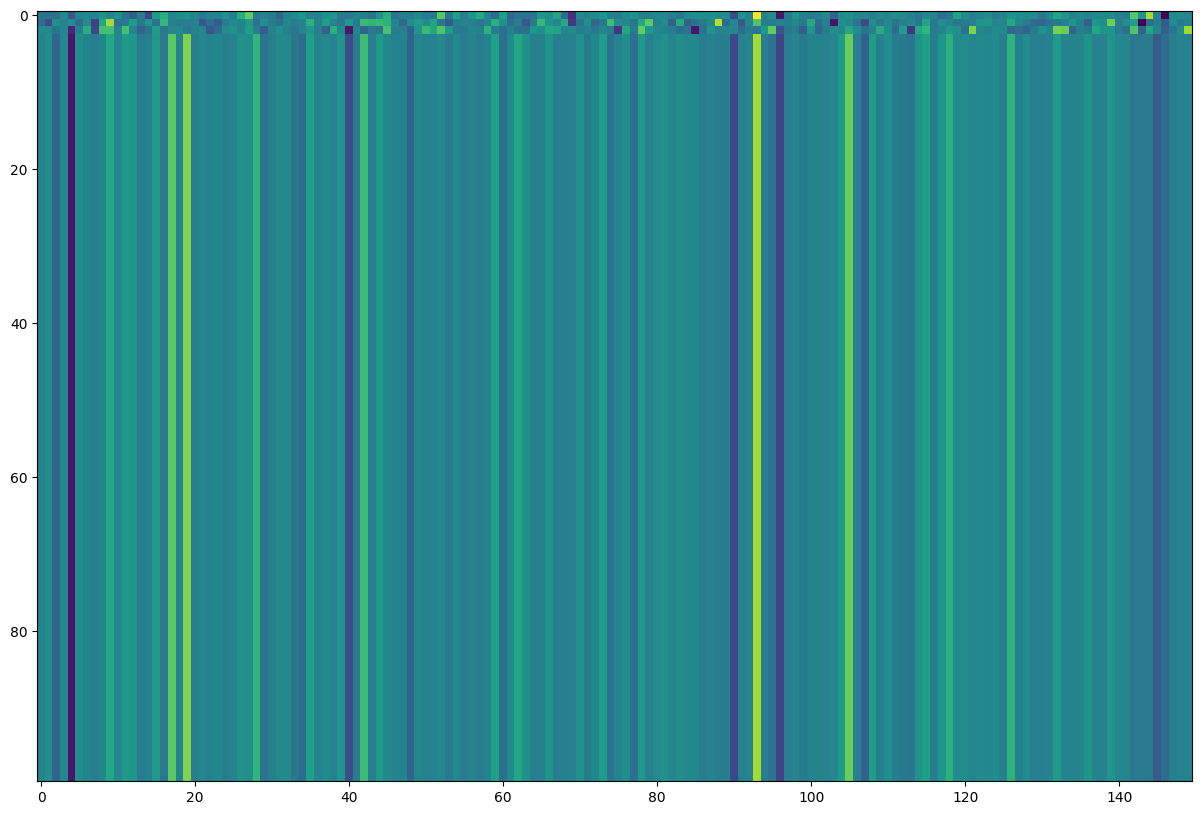

In [165]:
plt.figure(figsize=(100,10))
plt.imshow(poi_c2v.embedding_layer.predict(X[0:1]).reshape(-1,150))

4/4 [==============================] - 0s 2ms/step


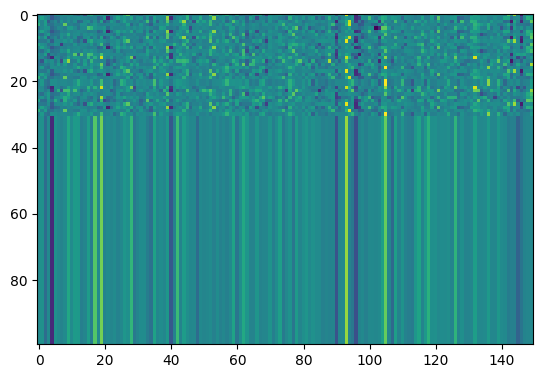

In [166]:
plt.imshow(poi_c2v.embedding_layer.predict(X[1]).reshape(-1,150))

In [171]:
fuzz.token_set_ratio('Car Craft', 'Carcraft Mot & Service Centre')

44

# Test layers

In [176]:
input_sequence = tf.keras.layers.Input(shape=100, name='input_sequence')
x = tf.keras.layers.Masking(mask_value=0)(input_sequence)
x = tf.keras.layers.Embedding(input_dim=100, output_dim=150, mask_zero=True)(x)
embedding_layer = tf.keras.models.Model(inputs=[input_sequence], outputs=x)

In [178]:
tf.keras.layers.Masking(mask_value=0)(X)


<tf.Tensor: shape=(2, 100), dtype=float32, numpy=
array([[20., 13., 24.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [20., 25., 31., 16., 29., 25., 12., 31., 20., 26., 25., 12., 23.,
         1., 13., 32., 30., 20., 25., 16., 30., 30.,  1., 24., 12., 14.,
        19., 20., 25., 16., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  

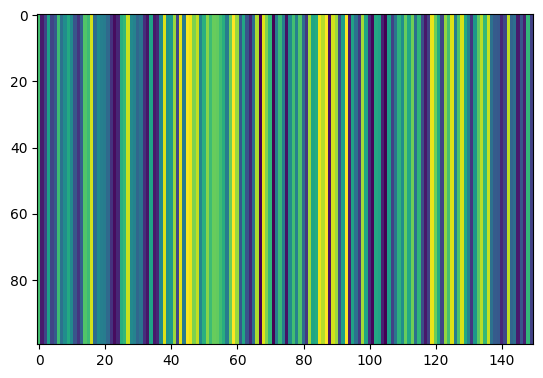

In [53]:
plt.imshow(embedding_layer(ones))